In [1]:
# shows the counting algorithm on a surveillance video, here only counts for cars
import torch
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import imp
import os
import aicity_utils as aic_utils
import prediction as model_arch
import efficientdet.track_count as tc
import vis_utils as vu
import count_class as cc
device = "cpu"
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]


In [2]:
# the example video is taken from youtube: https://www.youtube.com/watch?v=MNn9qKG2UFI&t=6s
if not os.path.exists('frames/clip'):
    video_path = "frames/camera.mp4"
    save_path = "frames/clip"
    print("extract frames from the video......")
    if not os.path.isfile(video_path):
        print("The video does not exist")
        print("please download video from path https://www.youtube.com/watch?v=MNn9qKG2UFI&t=6s and save it as camera.mp4 in the folder frames/")
    aic_utils.save_frame_from_video(video_path, save_path)
    print("Finish writing frames in the folder frames/clip")
print("There are %d frames " % len(os.listdir("frames/clip")))
frames = sorted(["frames/clip/" + v for v in os.listdir("frames/clip/") if '.jpg' in v])

There are 0 frames 


In [3]:
compound_coef = 0
subtract_bg = False
count_class = "car" # can also be "ped_car", or "ped"
class_index = [1] # the class label for person is 0, for car is 1
class_label = ["car"] # can also be ["person","car"], or ["person"]
use_precalculated_detection = False  # whether the detection is already given
ckpt_dir = None # use pre-trained EfficientDet weight on COCO dataset
threshold, nms_threshold, iou_threshold, student, params, \
    model = model_arch.get_parameters(compound_coef, count_class, 
                                      ckpt_dir, "aicity")

-----------------------------------------------------------------------------------
----Get parameter for EfficientDet0 to detect car-----
-----------------------------------------------------------------------------------
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', '

In [6]:
# single frame detection
imp.reload(model_arch)

im_path = str(np.random.choice(frames, 1)[0])
# im_path = "/project_scratch/bo/normal_data/aic2020/AIC20_track1/Dataset_A_Frame/annotations/bg_cam_1_dawn.jpg"
print(im_path)
_, output_stat0, im = model_arch.predict_single_image(im_path, model, compound_coef, 
                                                      use_background=False, only_person=count_class, 
                                                      show=True, student=False, filter_small_box=False, 
                                                      x_y_threshold=[], roi_interest=[])

/project_scratch/bo/normal_data/aic2020/AIC20_track1/Dataset_A_Frame/annotations/bg_cam_1_dawn.jpg
torch.Size([1, 3, 512, 512])


RuntimeError: The size of tensor a (124) must match the size of tensor b (126) at non-singleton dimension 3

Line 0 [0, 500, 750, 500]
Line 1 [900, 450, 1200, 550]


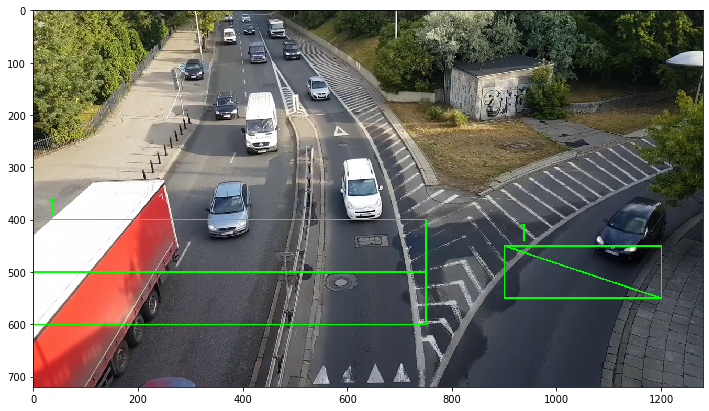

In [8]:
# Here, draw the lines
imp.reload(vu)
line0 = [0, 500, 750, 500]
line1 = [900, 450, 1200, 550]
vu.vis_lines([line0, line1], frames[851])

In [12]:
imp.reload(cc)
imp.reload(vu)
path_use = frames[::4] # perform counting every 4 frames, FPS ~ 24/4=6
save_video = True
show = False
resize = False
max_objects = 30
x_y_threshold = [1300, 0]
bike_speed = []
filter_small_box =False
track_counter = cc.TrackCount(model, compound_coef, threshold, nms_threshold, 
                              count_class, max_objects, 
                              iou_threshold, class_index, class_label, 
                              subtract_bg, student, params, resize, 
                              filter_small_box, minus_bg_norm=False,
                              x_y_threshold=x_y_threshold, 
                              bike_speed=bike_speed, 
                              activate_kalman_filter=True)
track_counter.run(path_use, "frames/track_count_stat", 
                  save_video, "frames/track_count_video.avi", 
                  show, use_precalculated_detection=False, predefine_line=[line0, line1])

  0%|          | 0/598 [00:00<?, ?it/s]

-----------------------------------------------------------------------------
model level 0
classification probability threshold 0.35
box prediction nms threshold 0.3
the objects that need to be counted car [1] ['car'] [0]
activating kalman filter to recover miss detect object True
iou threshold to identify whether two people are same person [0.15, 0.15, 0.15]
the input needs to be resized False
there should be maximum 30 objects in the memory
subtracting the background from the input frame False
The mean and standard deviation for the input frame [0.406, 0.456, 0.485] [0.225, 0.224, 0.229]
Normalizing the input frames after subtracting the background False
-----------------------------------------------------------------------------
counting use multiple boundaries [[0, 500, 750, 500], [900, 450, 1200, 550]]
saving staticis every 598
empty video statistics 0


 33%|███▎      | 196/598 [01:51<02:57,  2.26it/s]/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 598/598 [07:07<00:00,  1.40it/s]


In [15]:
imp.reload(vu)
track_count_stat = "frames/track_count_video/597"
vu.give_input_to_vispostim(track_count_stat, "temp", None, "car", ["car"], show=False, 
                           save_video=True, use_name="car", 
                           algo="boundary",                            
                           return_count=False, return_stat=False, jupyter=False,
                           box_standard = [], specify_direc=[], return_id_remove=False,
                           predefine_line=[line0, line1])

There are 598 images
